# A1: Model Evaluation

This notebook runs evaluations using our `main.py`

1) First we run a basic test grid over alphas (0, 0.5, 1.0) with & without unknown-words handling, for both whitespace and BPE
2) We pick the best setting and repeat a more fine-grained test over a region around it
3) We also demonstrate how diminishing returns with increasing unknown-word thresholds

In [40]:
import subprocess, pandas as pd
import matplotlib.pyplot as plt

MAIN = "main.py"

def run_cmd(cmd: str) -> str:
    p = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    return (p.stdout or "") + (p.stderr or "")

def parse_result_lines(txt: str):
    rows = []
    for line in txt.splitlines():
        if line.startswith("RESULT,"):
            parts = [x.strip() for x in line.split(",")]
            model = parts[1]
            unk_flag = parts[2]
            tokenization = parts[3]
            alpha = float(parts[4].split("=")[1])
            unk = parts[5].split("=")[1]
            merges = int(parts[6].split("=")[1])
            lower = parts[7].split("=")[1] == "True"
            ppl = float(parts[8].split("=")[1])

            rows.append({
                "model": model,
                "unk_flag": unk_flag,
                "tokenization": tokenization,
                "alpha": alpha,
                "unk_threshold": unk,
                "merges": merges,
                "lower": lower,
                "ppl": ppl
            })
    return rows

# 0. Unigram Output

In [60]:
import re

def parse_unigram_output(txt):
    nums = [float(x) for x in re.findall(r"([0-9]+\.[0-9]+)", txt)]
    return nums[-1] if nums else None

rows = []

# WS unigram w/ alpha=1.0 (Laplace)
out = run_cmd("python3 main.py -n 1 --alpha 1.0")
ppl_ws_uni = parse_unigram_output(out)
if ppl_ws_uni is not None:
    rows.append({"model":"unigram","tokenization":"whitespace","alpha":1.0,"ppl":ppl_ws_uni})

# BPE unigram w/ alpha=1.0 (Laplace)
out = run_cmd("python3 main.py -n 1 --alpha 1.0 --use_bpe")
ppl_bpe_uni = parse_unigram_output(out)
if ppl_bpe_uni is not None:
    rows.append({"model":"unigram","tokenization":"BPE","alpha":1.0,"ppl":ppl_bpe_uni})

import pandas as pd
unigram_df = pd.DataFrame(rows)
unigram_df

,model,tokenization,alpha,ppl
0,unigram,whitespace,1.0,294.4821
1,unigram,BPE,1.0,331.4118


## 1. Basic Test Grid
We run whitespace and BPE for alphas (0, 0.5, 1.0) and we:
- evaluate without unknown-word handling
- evaluate with unknown-word thresholds 1 and 2

In [ ]:
rows = []

# whitespace
for a in [0, 0.5, 1.0]:
    # no UNK
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a}")
    rows += parse_result_lines(out)
    # UNK thresholds
    for thr in [1, 2]:
        out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --unk_threshold {thr}")
        rows += parse_result_lines(out)

# BPE
for a in [0, 0.5, 1.0]:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --use_bpe")
    rows += parse_result_lines(out)
    for thr in [1, 2]:
        out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --use_bpe --unk_threshold {thr}")
        rows += parse_result_lines(out)

coarse_df = pd.DataFrame(rows)
coarse_df


,model,unk_flag,tokenization,alpha,unk_threshold,merges,lower,ppl
0,bigram,no_unk,whitespace,0.0,-,1000,True,43930.512142
1,bigram,with_unk,whitespace,0.0,1,1000,True,5854.995796
2,bigram,with_unk,whitespace,0.0,2,1000,True,3395.161182
3,bigram,no_unk,whitespace,0.5,-,1000,True,759.068360
4,bigram,with_unk,whitespace,0.5,1,1000,True,316.724179
5,bigram,with_unk,whitespace,0.5,2,1000,True,227.706382
6,bigram,no_unk,whitespace,1.0,-,1000,True,1048.131494
7,bigram,with_unk,whitespace,1.0,1,1000,True,429.084062
8,bigram,with_unk,whitespace,1.0,2,1000,True,301.144218
9,bigram,no_unk,BPE,0.0,-,1000,True,876.336065


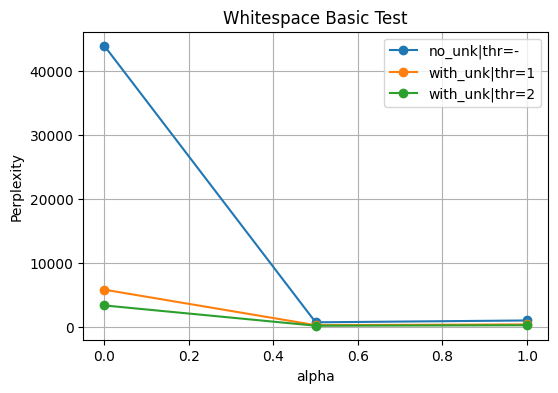

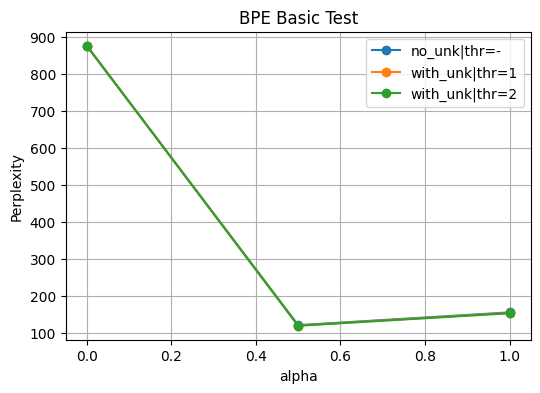

In [122]:
sub = coarse_df[coarse_df["tokenization"].str.lower() == "whitespace"].copy()
lines = {}
for _, r in sub.iterrows():
    key = f'{r["unk_flag"]}|thr={r["unk_threshold"]}'
    lines.setdefault(key, []).append((float(r["alpha"]), float(r["ppl"])))
plt.figure(figsize=(6,4))
for key, pts in lines.items():
    pts.sort(key=lambda t: t[0])
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    plt.plot(xs, ys, marker="o", label=key)
plt.xlabel("alpha")
plt.ylabel("Perplexity")
plt.title(f"Whitespace Basic Test")
plt.grid(True)
plt.legend()
plt.show()

sub = coarse_df[coarse_df["tokenization"].str.lower() == "bpe"].copy()
lines = {}
for _, r in sub.iterrows():
    key = f'{r["unk_flag"]}|thr={r["unk_threshold"]}'
    lines.setdefault(key, []).append((float(r["alpha"]), float(r["ppl"])))
plt.figure(figsize=(6,4))
for key, pts in lines.items():
    pts.sort(key=lambda t: t[0])
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    plt.plot(xs, ys, marker="o", label=key)
plt.xlabel("alpha")
plt.ylabel("Perplexity")
plt.title(f"BPE Basic Test")
plt.grid(True)
plt.legend()
plt.show()


### Analysis

When there is no smoothing (alpha=0) perplexity is extremely high, particularly in whitespace tokenization because the seen bigrams get probability of 0. When we add unknown-word handling that lowers perplexity significantly, confirming taht rare word replacement is important. When alpha=0.5, we see a big drop in ppl, showing that smoothing stabilized the model. When we increase it further to alpha=1.0, ppl actually gets worse, as too much smoothing would hide away the true counts. BPE has lower perplexity across all values of alpha, which indicates that sub-word tokenization is better with sparse data as in our case.

# 2. More fine-grained testing

From the previous results:
- whitespace improves a lot with unknown-word handling and and a moderate alpha around 0.25-0.50
- BPE is much better overall, and the best value of alpha it paired with is small around 0.2-0.3 when unknown threshold was 2


In [ ]:
rows = []

alphas_fine = [round(x, 2) for x in [0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80]]

# whitespace
for a in alphas_fine:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --unk_threshold 2")
    rows += parse_result_lines(out)

# BPE
for a in alphas_fine:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --use_bpe --unk_threshold 2")
    rows += parse_result_lines(out)

fine_df = pd.DataFrame(rows)
fine_df


,model,unk_flag,tokenization,alpha,unk_threshold,merges,lower,ppl
0,bigram,with_unk,whitespace,0.10,2,1000,True,141.075068
1,bigram,with_unk,whitespace,0.15,2,1000,True,155.079999
2,bigram,with_unk,whitespace,0.20,2,1000,True,167.691763
3,bigram,with_unk,whitespace,0.25,2,1000,True,179.271375
4,bigram,with_unk,whitespace,0.30,2,1000,True,190.051600
5,bigram,with_unk,whitespace,0.35,2,1000,True,200.188650
6,bigram,with_unk,whitespace,0.40,2,1000,True,209.792682
7,bigram,with_unk,whitespace,0.45,2,1000,True,218.944710
8,bigram,with_unk,whitespace,0.50,2,1000,True,227.706382
9,bigram,with_unk,whitespace,0.55,2,1000,True,236.125929


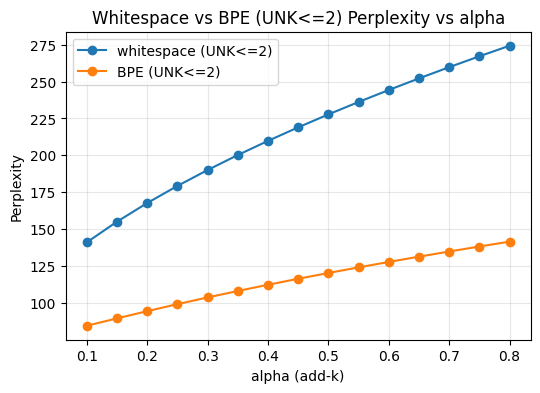

In [123]:
sub_ws = fine_df[
    (fine_df["tokenization"].str.lower()=="whitespace") &
    (fine_df["unk_flag"]=="with_unk") &
    (fine_df["unk_threshold"].astype(str)=="2")
].copy()

sub_bpe = fine_df[
    (fine_df["tokenization"].str.lower()=="bpe") &
    (fine_df["unk_flag"]=="with_unk") &
    (fine_df["unk_threshold"].astype(str)=="2")
].copy()

sub_ws = sub_ws.sort_values("alpha")
sub_bpe = sub_bpe.sort_values("alpha")

plt.figure(figsize=(6,4))
plt.plot(sub_ws["alpha"], sub_ws["ppl"], marker="o", label="whitespace (UNK<=2)")
plt.plot(sub_bpe["alpha"], sub_bpe["ppl"], marker="o", label="BPE (UNK<=2)")
plt.xlabel("alpha (add-k)")
plt.ylabel("Perplexity")
plt.title("Whitespace vs BPE (UNK<=2) Perplexity vs alpha")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Analysis

Here we ran a more fine-grained test, and as we can see, for both whitepace and BPE, the ppl increased smoothly as alpha got larger. The best result was based on the very first alpha setting here. This means, that the actual best setting may still lie between 0.0 and 0.1. Let's further test within that range.


In [105]:
rows = []

alphas_finer = [round(x, 2) for x in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]]

# whitespace
for a in alphas_finer:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --unk_threshold 2")
    rows += parse_result_lines(out)

# BPE
for a in alphas_finer:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha {a} --use_bpe --unk_threshold 2")
    rows += parse_result_lines(out)

finer_df = pd.DataFrame(rows)
finer_df


,model,unk_flag,tokenization,alpha,unk_threshold,merges,lower,ppl
0,bigram,with_unk,whitespace,0.01,2,1000,True,115.517799
1,bigram,with_unk,whitespace,0.02,2,1000,True,115.905769
2,bigram,with_unk,whitespace,0.03,2,1000,True,118.650213
3,bigram,with_unk,whitespace,0.04,2,1000,True,121.891068
4,bigram,with_unk,whitespace,0.05,2,1000,True,125.230780
5,bigram,with_unk,whitespace,0.06,2,1000,True,128.547605
6,bigram,with_unk,whitespace,0.07,2,1000,True,131.799417
7,bigram,with_unk,whitespace,0.08,2,1000,True,134.972319
8,bigram,with_unk,whitespace,0.09,2,1000,True,138.063574
9,bigram,with_unk,BPE,0.01,2,1000,True,84.969960


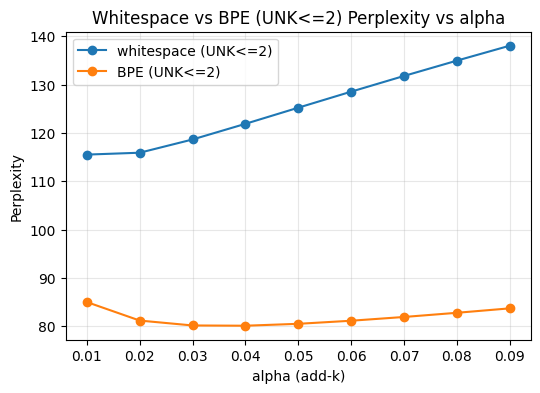

In [124]:
sub_ws = finer_df[
    (finer_df["tokenization"].str.lower()=="whitespace") &
    (finer_df["unk_flag"]=="with_unk") &
    (finer_df["unk_threshold"].astype(str)=="2")
].copy()

sub_bpe = finer_df[
    (finer_df["tokenization"].str.lower()=="bpe") &
    (finer_df["unk_flag"]=="with_unk") &
    (finer_df["unk_threshold"].astype(str)=="2")
].copy()

sub_ws = sub_ws.sort_values("alpha")
sub_bpe = sub_bpe.sort_values("alpha")

plt.figure(figsize=(6,4))
plt.plot(sub_ws["alpha"], sub_ws["ppl"], marker="o", label="whitespace (UNK<=2)")
plt.plot(sub_bpe["alpha"], sub_bpe["ppl"], marker="o", label="BPE (UNK<=2)")
plt.xlabel("alpha (add-k)")
plt.ylabel("Perplexity")
plt.title("Whitespace vs BPE (UNK<=2) Perplexity vs alpha")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Analysis

As can be seen here, upon further zooming into this range, the ppl first drops and then increases, meaning the optimal alpha lies somewhere beetween 0.02-0.05

## 3. Exploring how unknown-word threshold affects ppl

Here we keep alpha constant and explore different unknown-word handling thresholds for both whitespace and BPE

In [ ]:
thr_rows = []

# whitespace
for thr in [0,1,2,3,4]:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha 0.5 --unk_threshold {thr}")
    thr_rows += parse_result_lines(out)

# BPE
for thr in [0,1,2,3,4]:
    out = run_cmd(f"python3 {MAIN} -n 2 --alpha 0.5 --use_bpe --unk_threshold {thr}")
    thr_rows += parse_result_lines(out)

thr_df = pd.DataFrame(thr_rows)
thr_df


,model,unk_flag,tokenization,alpha,unk_threshold,merges,lower,ppl
0,bigram,with_unk,whitespace,0.5,0,1000,True,759.165487
1,bigram,with_unk,whitespace,0.5,1,1000,True,316.724179
2,bigram,with_unk,whitespace,0.5,2,1000,True,227.706382
3,bigram,with_unk,whitespace,0.5,3,1000,True,181.246971
4,bigram,with_unk,whitespace,0.5,4,1000,True,149.044534
5,bigram,with_unk,BPE,0.5,0,1000,True,121.867286
6,bigram,with_unk,BPE,0.5,1,1000,True,120.889644
7,bigram,with_unk,BPE,0.5,2,1000,True,120.331130
8,bigram,with_unk,BPE,0.5,3,1000,True,119.419850
9,bigram,with_unk,BPE,0.5,4,1000,True,118.540894


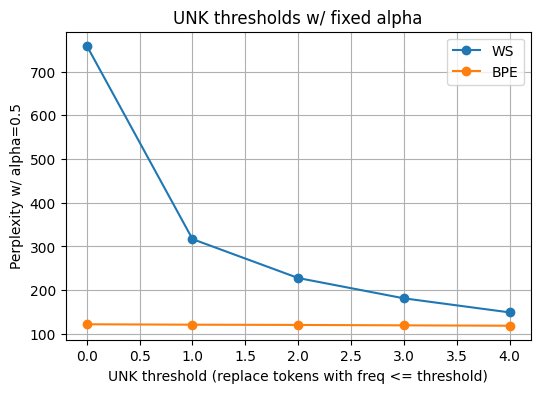

In [72]:
plt.figure(figsize=(6,4))
for tok in ["whitespace", "BPE"]:
    sub = thr_df[thr_df["tokenization"].str.lower() == tok.lower()].copy()
    sub["thr_num"] = pd.to_numeric(sub["unk_threshold"], errors="coerce")
    sub = sub.sort_values("thr_num")
    plt.plot(sub["thr_num"], sub["ppl"], marker="o", label=("BPE" if tok.lower()=="bpe" else "WS"))
plt.xlabel("UNK threshold (replace tokens with freq <= threshold)")
plt.ylabel("Perplexity w/ alpha=0.5")
plt.title("UNK thresholds w/ fixed alpha")
plt.grid(True)
plt.legend()
plt.show()


### Analysis

Here we can see that for whitespace, increasing the UNK threshold reduced perplexity significantly, especially from 0.0 to 1.0. and 1 to 2.0. The gains however reduced with higher UNK thresholds, showing diminishing returns. For BPE the threshold made almost no difference, reducing it only ever so slightly (not visible even in the graph, but you can see it in the output). This makes sense becuase BPE already splits rare words into frequenc subwords. Therefore, unknown-word handling is really only necesssary for whitespace.

## 4. Best setting (with UNK <= 2)

In [114]:
all_df = pd.concat([coarse_df, fine_df, finer_df, thr_df], ignore_index=True)

print("\nBest setting:")
display(all_df.sort_values("ppl").head(1))



Best setting:


,model,unk_flag,tokenization,alpha,unk_threshold,merges,lower,ppl
60,bigram,with_unk,BPE,0.04,2,1000,True,80.076628


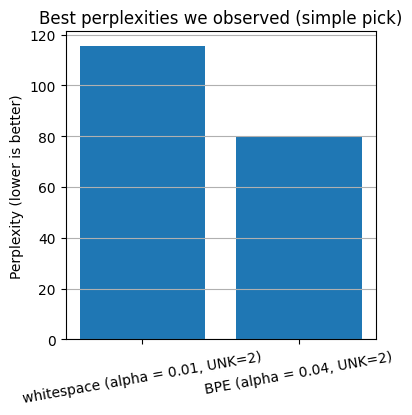

In [115]:
best_whitespace = all_df[all_df["tokenization"].str.lower()=="whitespace"].sort_values("ppl").head(1)
best_bpe = all_df[all_df["tokenization"].str.lower()=="bpe"].sort_values("ppl").head(1)

c2 = []
v2 = []

if len(best_whitespace) > 0:
    c2.append(f'whitespace (alpha = {best_whitespace["alpha"].iloc[0]}, UNK={best_whitespace["unk_threshold"].iloc[0]})')
    v2.append(float(best_whitespace["ppl"].iloc[0]))

if len(best_bpe)  > 0:
    c2.append(f'BPE (alpha = {best_bpe["alpha"].iloc[0]}, UNK={best_bpe["unk_threshold"].iloc[0]})')
    v2.append(float(best_bpe["ppl"].iloc[0]))

plt.figure(figsize=(4,4))
plt.bar(range(len(v2)), v2)
plt.xticks(range(len(v2)), c2, rotation=10)

plt.ylabel("Perplexity (lower is better)")
plt.title("Best perplexities we observed (simple pick)")
plt.grid(axis="y")
plt.show()


### Analysis

From all experiments (with UNK <= 2), the best whitespace configuration with lowest ppl was alpha=0.1, UNK=2 with ppl of around 115

For BPE, the best was alpha=0.1, UNK=2 with perplexity of around 80. This is a huge improvement over whitespace tokenization, and also it confirms that the optimal alpha is very small, and unknown-word handling helps for whitespace but not much for BPE

This perplexity would be even lower if we use a higher UNK threshold, but the alpha would likely stay around the same lower region

## X. Save CSVs


In [ ]:
results_df = pd.concat([unigram_df, coarse_df, fine_df, finer_df, thr_df], ignore_index=True)
results_df.to_csv("results_all.csv", index=False)
print("Saved: results_all.csv")

Saved: coarse_results.csv, fine_results.csv, thr_results.csv, best_table_auto.csv
